In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RHI825214 - White alone, not Hispanic or Latino, percent, 2014
# EDU635213 / Edu_highschool- High school graduate or higher, percent of persons age 25+, 2009-2013
# Edu_bachelors?
# POP060210 / Density - Population per square mile, 2010

# predict:
# Trump



In [2]:
data_path = 'votes.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,Unnamed: 0,X,combined_fips,votes_dem_2016,votes_gop_2016,total_votes_2016,Clinton,Trump,TrumpWin,diff_2016,...,AFN120207,BPS030214,LND110210,Density,Clinton_Obama,Trump_Romney,Trump_Prediction,Clinton_Prediction,Trump_Deviation,Clinton_Deviation
0,30,29,1001,5908,18110,24661,0.239569,0.734358,1,12202,...,88157,131,594.44,91.8,-0.026189,0.008021,0.620859,0.340493,-0.113499,0.100924
1,31,30,1003,18409,72780,94090,0.195653,0.773515,1,54371,...,436955,1384,1589.78,114.6,-0.020013,-0.000383,0.586749,0.359502,-0.186766,0.163849
2,32,31,1005,4848,5431,10390,0.466603,0.522714,1,583,...,0,8,884.88,31.0,-0.045920,0.039339,0.517832,0.474693,-0.004882,0.008090
3,33,32,1007,1874,6733,8748,0.214220,0.769662,1,4859,...,10757,19,622.58,36.8,-0.047965,0.038998,0.692227,0.286031,-0.077434,0.071811
4,34,33,1009,2150,22808,25384,0.084699,0.898519,1,20658,...,20941,3,644.78,88.9,-0.038779,0.033590,0.789649,0.177490,-0.108870,0.092791


In [4]:
columns = ['TrumpWin', 'Edu_highschool', 'White', 'Income', 'INC110213', 'Poverty', 'Density']
# 'population_change',
rides = rides[columns]
rides.head()

,TrumpWin,Edu_highschool,White,Income,INC110213,Poverty,Density
0,1,85.6,0.779,24571,53682,12.1,91.8
1,1,89.1,0.871,26766,50221,13.9,114.6
2,1,73.7,0.502,16829,32911,26.7,31.0
3,1,77.5,0.763,17427,36447,18.1,36.8
4,1,77.0,0.960,20730,44145,15.8,88.9


In [5]:
dummy_fields = []
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = []
data = rides.drop(fields_to_drop, axis=1)
data.head()

,TrumpWin,Edu_highschool,White,Income,INC110213,Poverty,Density
0,1,85.6,0.779,24571,53682,12.1,91.8
1,1,89.1,0.871,26766,50221,13.9,114.6
2,1,73.7,0.502,16829,32911,26.7,31.0
3,1,77.5,0.763,17427,36447,18.1,36.8
4,1,77.0,0.960,20730,44145,15.8,88.9


In [6]:
quant_features = columns # columns[1:]
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data.head()

,TrumpWin,Edu_highschool,White,Income,INC110213,Poverty,Density
0,0.43118,0.157150,-0.475048,0.181585,0.669478,-0.710149,-0.097974
1,0.43118,0.663505,0.107658,0.577733,0.376226,-0.432799,-0.084814
2,0.43118,-1.564457,-2.229498,-1.215672,-1.090461,1.539465,-0.133067
3,0.43118,-1.014700,-0.576388,-1.107746,-0.790854,0.214350,-0.129720
4,0.43118,-1.087036,0.671362,-0.511629,-0.138598,-0.140041,-0.099648


In [7]:
num_total_rows = data.shape[0]

# Save 20% of data for testing
test_data = data.sample(n=round(.20*num_total_rows))

# Remove test data
data = data.drop(test_data.index)

# Split out of remaining data some for validation
num_remain_rows = data.shape[0]

train_data = data.sample(n=round(.75*num_remain_rows))

val_data = data.drop(train_data.index)

print(test_data.shape)
print(train_data.shape)
print(val_data.shape)

(622, 7)
(1868, 7)
(622, 7)


In [8]:
# Separate the data into features and targets
target_fields = ['TrumpWin']
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]
val_features, val_targets = val_data.drop(target_fields, axis=1), val_data[target_fields]

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            
            
            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = 1 * final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.
            
            # TODO: Calculate the hidden layer's contribution to the error 
            # QUESTION - Why am I transposing here- conceptually I mean- what do the numbers now represent?
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
        
            
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]
            
            
            
            # delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

    
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        # QUESTION - Why does the order switch here (other than making match work) when usually we lead outputs * weights
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = 1 * final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [11]:
import sys

### Set the hyperparameters here ###
iterations = 5000 # based on graph of 10k iterations should be ~1500-2000 to prevent overfitting
learning_rate = 0.1 # .01 was way too small
hidden_nodes = 30 #20 nodes- 79.1% accuracy, 25- 79.5, 30-78.7. 50-79.4 60- 79.7, 70-78.1
#60-78.1, 30- 78
# 30 without pop change 79.4
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['TrumpWin']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['TrumpWin'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['TrumpWin'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.494 ... Validation loss: 0.594

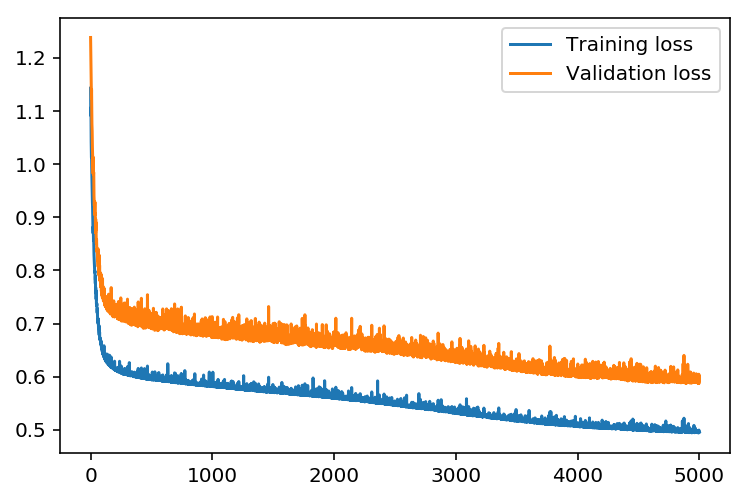

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

529


array([[412, 117],
       [ 11,  82]])

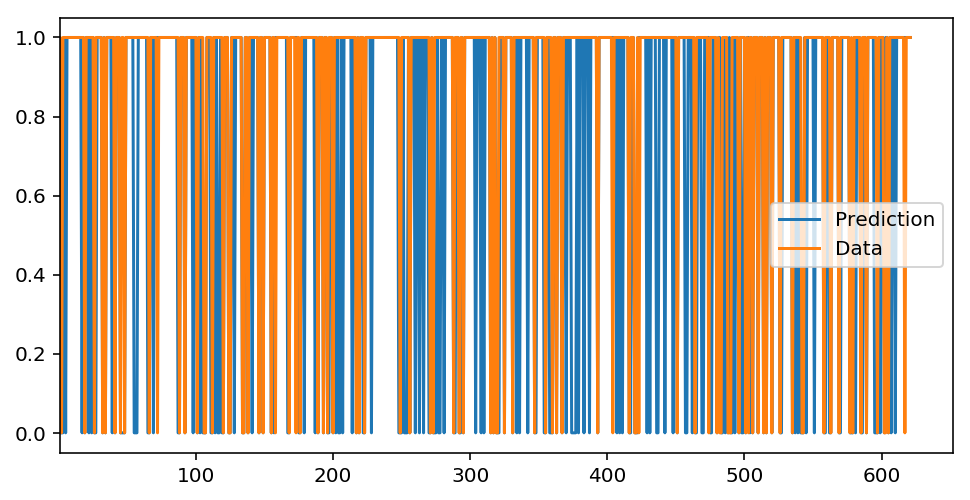

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['TrumpWin']
predictions = network.run(test_features).T*std + mean

predictions_mean = np.mean(predictions[0])
norm_predictions = []

for prediction in predictions[0]:
    if prediction >= predictions_mean:
        norm_predictions.append(1.0)
    else:
        norm_predictions.append(0.0)
        
norm_data = []
sum = 0

for value in (test_targets['TrumpWin']*std + mean).values:
    norm_data.append(round(value))
    if round(value) == 1.0:
        sum += 1
print(sum)

ax.plot(norm_predictions, label='Prediction')
ax.plot(norm_data, label='Data')
ax.set_xlim(left=len(predictions))
ax.legend()

from sklearn.metrics import confusion_matrix
y_true = norm_data
y_pred = norm_predictions
confusion_matrix(y_true, y_pred, labels=[1, 0])

# from sklearn.metrics import accuracy_score
# accuracy_score(y_true, y_pred)

# from sklearn.metrics import r2_score
# r2_score(y_true, y_pred) 

In [14]:
(387+69)/ (387+150+16+69)

0.7331189710610932

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.79421221864951763

In [16]:
537 / (387+150+16+69)

0.8633440514469454